In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
from scipy.stats import zscore

import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

sc.settings.verbosity = 2

# Load in data

In [2]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/fib_ihsc_processed.h5ad"
adata = sc.read_h5ad(fpath)
adata.X = adata.layers['log_norm'].copy()
adata

CPU times: user 1.04 s, sys: 2.69 s, total: 3.73 s
Wall time: 21.4 s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_colors', 'cluster_str_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 

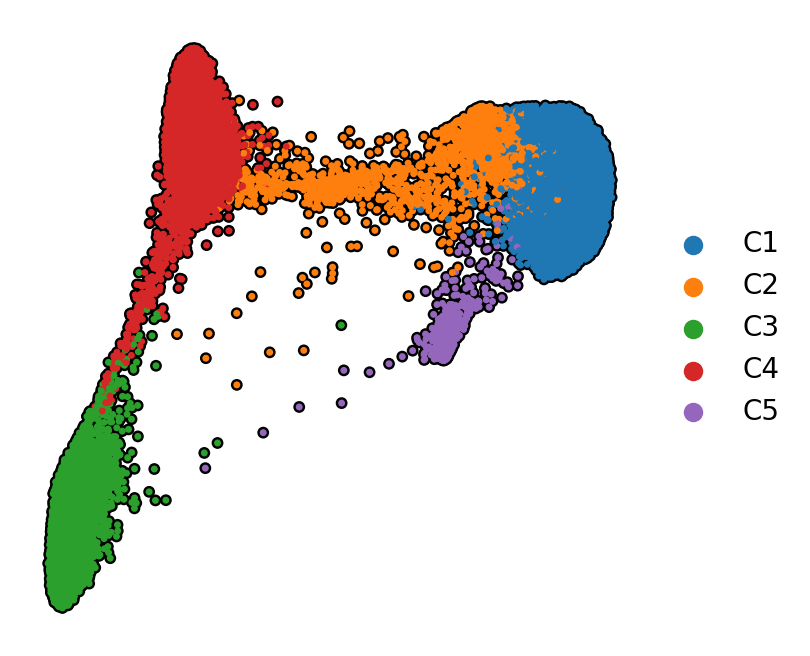

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata,
    color=['cluster_str'],
    size=25,
    ncols=1,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
    title='',
    # legend_loc='none',
)

# DGE

In [4]:
def get_significant_DEGs(df, alpha=0.05, logfc_thresh=0.5, pct_nz_thresh=0.0):
    
    tmp = df.copy()
    
    print(f"Filtering for significant DEGs (adjusted p-value < {alpha}, logfoldchange > {logfc_thresh})...")

    tmp['abs_lfc'] = tmp['logfoldchanges'].apply('abs')
    tmp = tmp[(tmp['abs_lfc'] > logfc_thresh) & (tmp['pvals_adj'] < alpha)]

    if pct_nz_thresh != 0.0:
        if 'pct_nz_reference' in tmp.columns:
            # make sure either group of interest OR reference has % cells expressing above threshold
            tmp = tmp[(tmp['pct_nz_group'] > pct_nz_thresh) | (tmp['pct_nz_reference'] > pct_nz_thresh)]
            print(f"Removed genes expressed in less than {pct_nz_thresh*100}% of group OR reference cells.")
        
        else:
            # Only apply pct_nz_group filter to upregulated genes
            upregulated_mask = tmp['logfoldchanges'] > 0
            keep_mask = (~upregulated_mask) | (tmp['pct_nz_group'] > pct_nz_thresh)
            tmp = tmp[keep_mask]

            tmp = tmp[tmp['pct_nz_group'] > pct_nz_thresh]
            print(f"Removed upregaulted genes expressed in less than {pct_nz_thresh*100}% of cells. Kept all downregulated genes.")
    
    print(f"N unique significant DEGs: {tmp['names'].nunique()}\n")
    
    return tmp

In [11]:
# sc.tl.rank_genes_groups(
#     adata, 
#     groupby='cluster_str',
#     method='wilcoxon',
#     layer='log_norm',
#     use_raw=False,
#     pts=True,
#     key_added='cluster_deg',
# )

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='cluster_deg',
    pval_cutoff=0.05,
)

# sig = get_significant_DEGs(deg, logfc_thresh=0.5)
print(deg.shape)
print(f"N unique DEGs: {deg['names'].nunique()}")
deg.head()

(43238, 8)
N unique DEGs: 12380


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,C1,CLU,80.586487,3.712294,0.0,0.0,0.996546,0.660744
1,C1,KRT18,79.765419,4.051322,0.0,0.0,0.997697,0.465282
2,C1,MT-ND3,78.430496,1.923796,0.0,0.0,0.999770,0.943958
3,C1,MT-CYB,78.124748,1.748896,0.0,0.0,0.999309,0.932386
4,C1,FLNB,77.184853,3.148286,0.0,0.0,0.962468,0.428103


In [15]:
deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='cluster_deg',
    pval_cutoff=0.05,
)
print(f"Initial n genes: {deg['names'].nunique()}")

# gene info
gtf = adata.var[['gene_type']].copy()
gtf = gtf.reset_index(names='names')
print(gtf.shape)


# merge with gtf file
deg = pd.merge(deg, gtf, how='left', on='names')
print(f"After merging w GTF: {deg['names'].nunique()}")

# remove ENSG and MT- genes
deg = deg[~deg['names'].str.startswith(('ENSG', 'MT-'))]

# filter for protein-coding
deg = deg[deg['gene_type'] == 'protein_coding']

print(f"Protein-coding n genes: {deg['names'].nunique()}")
deg.head()

Initial n genes: 12380
(23434, 2)
After merging w GTF: 12380
Protein-coding n genes: 10760


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,gene_type
0,C1,CLU,80.586487,3.712294,0.0,0.0,0.996546,0.660744,protein_coding
1,C1,KRT18,79.765419,4.051322,0.0,0.0,0.997697,0.465282,protein_coding
4,C1,FLNB,77.184853,3.148286,0.0,0.0,0.962468,0.428103,protein_coding
5,C1,MGP,76.849617,4.776715,0.0,0.0,0.995165,0.322125,protein_coding
7,C1,S100A6,76.231033,1.291574,0.0,0.0,1.000000,1.000000,protein_coding


In [12]:
# gdf = adata.var[['gene_type']].copy()
# gdf = gdf.reset_index(names='names')
# print(gdf.shape)

# pdf = pd.merge(deg, gdf, how='left', on='names')

# # remove ENSG and MT- genes
# pdf = pdf[~pdf['names'].str.startswith(('ENSG', 'MT-'))]

# # filter for protein-coding
# pdf = pdf[pdf['gene_type'] == 'protein_coding']

# print(f"N unique protein-coding DEGs: {pdf['names'].nunique()}")
# print(pdf.shape)
# pdf.head()

(23434, 2)
N unique protein-coding DEGs: 10760
(38625, 9)


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,gene_type
0,C1,CLU,80.586487,3.712294,0.0,0.0,0.996546,0.660744,protein_coding
1,C1,KRT18,79.765419,4.051322,0.0,0.0,0.997697,0.465282,protein_coding
4,C1,FLNB,77.184853,3.148286,0.0,0.0,0.962468,0.428103,protein_coding
5,C1,MGP,76.849617,4.776715,0.0,0.0,0.995165,0.322125,protein_coding
7,C1,S100A6,76.231033,1.291574,0.0,0.0,1.000000,1.000000,protein_coding


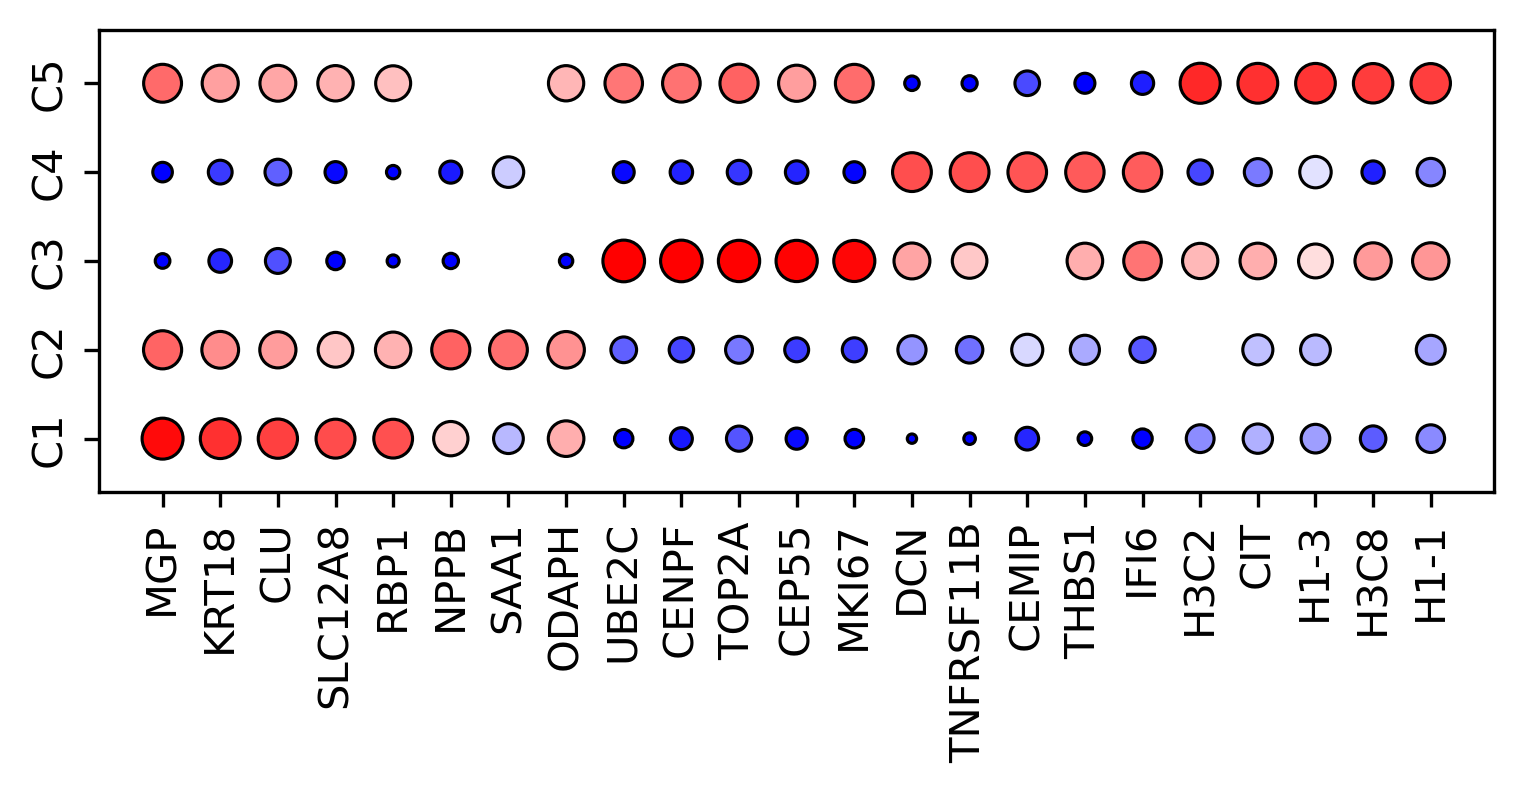

In [16]:
top_n_genes = 5
pct_nz_group = 0.1

groups = ['C1', 'C2', 'C3', 'C4', 'C5']
groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg[deg['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
plot_df = deg[deg['names'].isin(deg_genes)].copy()

plot_df['label'] = plot_df['group'].apply(lambda x: x.replace("_", " "))
plot_df = plot_df.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

plot_df['names'] = pd.Categorical(plot_df['names'], categories=deg_genes, ordered=True)
plot_df['label'] = pd.Categorical(plot_df['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.scatterplot(
    data=plot_df,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-5, 5),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.15)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels, rotation=90, va='center')

plt.show()

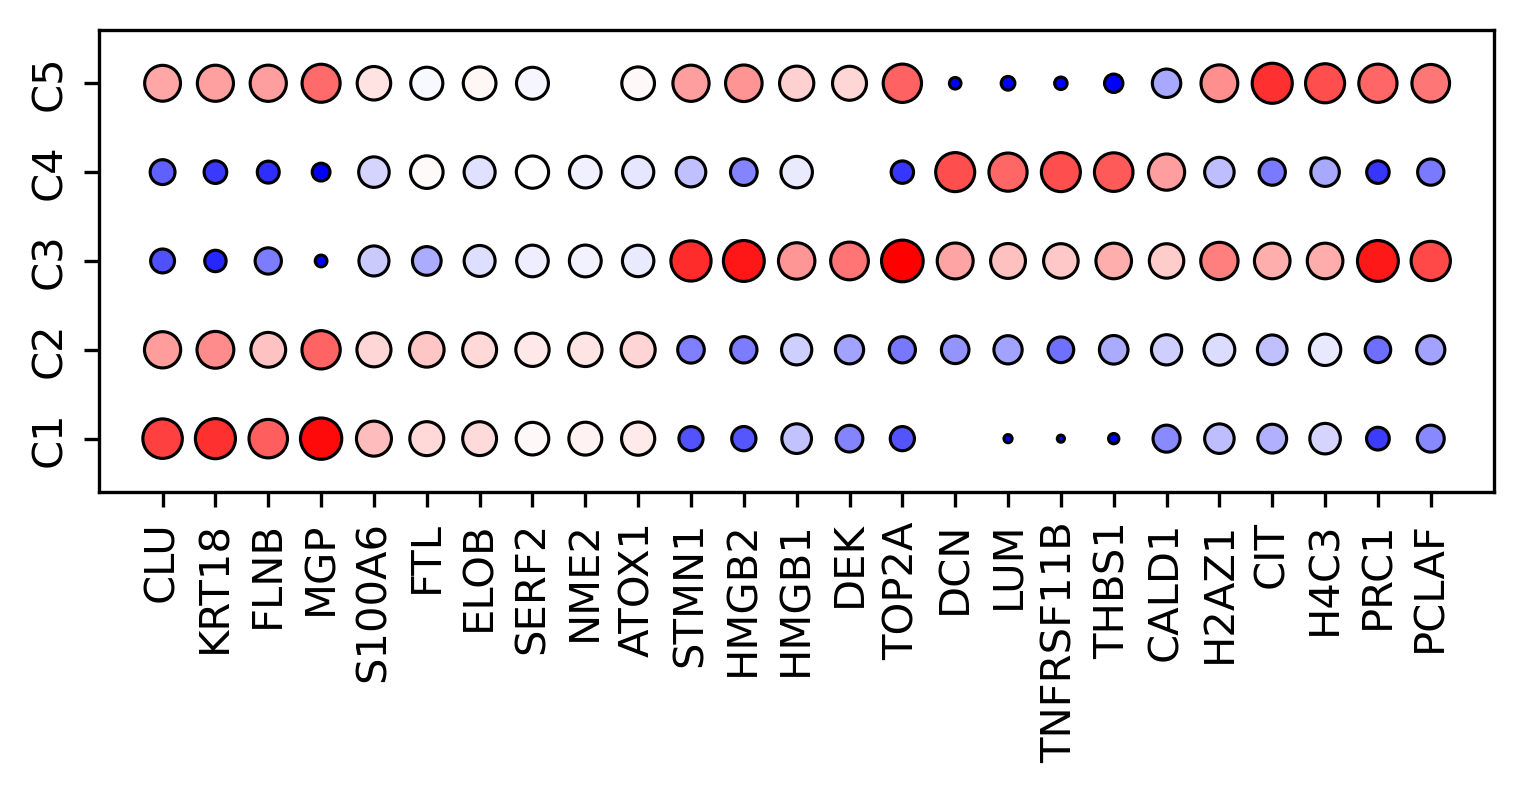

In [17]:
# sorted by SCORES
top_n_genes = 5
pct_nz_group = 0.1

groups = ['C1', 'C2', 'C3', 'C4', 'C5']
groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg[deg['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', 'scores'], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
pdf = deg[deg['names'].isin(deg_genes)].copy()

pdf['label'] = pdf['group'].apply(lambda x: x.replace("_", " "))
pdf = pdf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

pdf['names'] = pd.Categorical(pdf['names'], categories=deg_genes, ordered=True)
pdf['label'] = pd.Categorical(pdf['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.scatterplot(
    data=pdf,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-5, 5),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.15)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels, rotation=90, va='center')

plt.show()

In [18]:
# get DEGs by broad grouping
# adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C2', 'C3']), 'reprogramming', 'control')
mapping = {
    'C1': 'reprogramming',
    'C2': 'reprogramming',
    'C3': 'control',
    'C4': 'control',
    'C5': 'reprogramming',
}

adata.obs['group'] = adata.obs['cluster_str'].map(mapping)

sc.tl.rank_genes_groups(
    adata, 
    groupby='group',
    method='wilcoxon',
    layer='log_norm',
    use_raw=False,
    pts=True,
    key_added='broad_deg',
)

deg1 = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='broad_deg',
    pval_cutoff=0.05,
)
print(f"Initial n genes: {deg1['names'].nunique()}")

# merge with gtf file
deg1 = pd.merge(deg1, gtf, how='left', on='names')
print(f"After merging w GTF: {deg1['names'].nunique()}")

# remove ENSG and MT- genes
deg1 = deg1[~deg1['names'].str.startswith(('ENSG', 'MT-'))]

# filter for protein-coding
deg1 = deg1[deg1['gene_type'] == 'protein_coding']

print(f"Protein-coding n genes: {deg1['names'].nunique()}")
deg1.head()

ranking genes


... storing 'group' as categorical


    finished (0:00:37)
Initial n genes: 11332
After merging w GTF: 11332
Protein-coding n genes: 9575


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,gene_type
0,control,IFI6,105.454208,5.835438,0.0,0.0,0.995983,0.451773,protein_coding
1,control,DCN,101.970818,5.651833,0.0,0.0,0.998228,0.167372,protein_coding
2,control,LY6E,101.798431,2.985550,0.0,0.0,0.995038,0.735152,protein_coding
3,control,IFI16,100.669479,5.134956,0.0,0.0,0.965501,0.211002,protein_coding
4,control,IFITM3,100.001633,1.923457,0.0,0.0,1.000000,0.994163,protein_coding


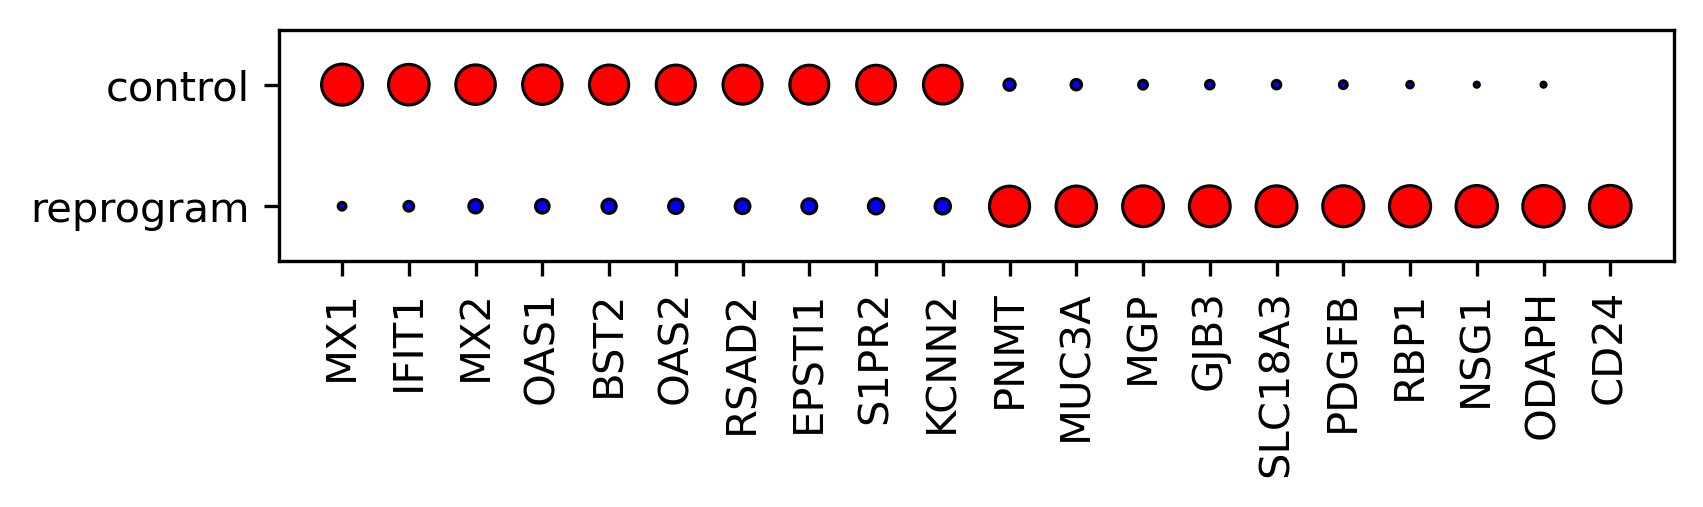

In [19]:
top_n_genes = 10
pct_nz_group = 0.1

gene_selection_col = 'logfoldchanges'

groups = ['reprogram', 'control']
groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg1[deg1['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', gene_selection_col], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
pdf = deg1[deg1['names'].isin(deg_genes)].copy()

pdf['label'] = pdf['group'].map({
    "control" : "control",
    "reprogramming" : "reprogram",
})
pdf = pdf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
gene_order = pdf['names'].unique()

pdf['names'] = pd.Categorical(pdf['names'], categories=gene_order, ordered=True)
pdf['label'] = pd.Categorical(pdf['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1

sns.scatterplot(
    data=pdf,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-5, 5),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.45)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels)#, rotation=90, va='center')

plt.show()

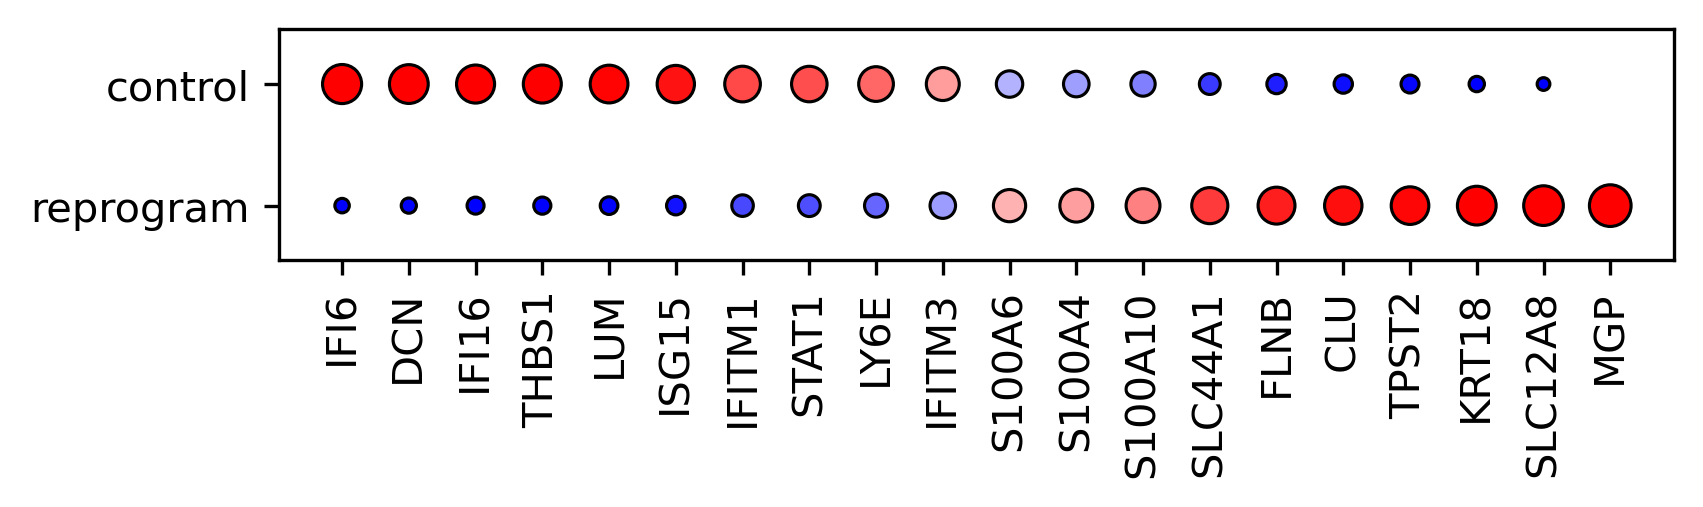

In [20]:
# selected by score
top_n_genes = 10
pct_nz_group = 0.1

gene_selection_col = 'scores'

groups = ['reprogram', 'control']
groups.reverse()

# filter out genes only expressed in a few cells, robust DEG
gdf = deg1[deg1['pct_nz_group'] > pct_nz_group].copy()

# sort by logfc and select top de genes per group
gdf = gdf.sort_values(by=['group', gene_selection_col], ascending=[True, False])
gdf = gdf.groupby('group').head(top_n_genes)

deg_genes = gdf['names'].unique()

# now filter the full frame for these genes
pdf = deg1[deg1['names'].isin(deg_genes)].copy()

pdf['label'] = pdf['group'].map({
    "control" : "control",
    "reprogramming" : "reprogram",
})
pdf = pdf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
gene_order = pdf['names'].unique()

pdf['names'] = pd.Categorical(pdf['names'], categories=gene_order, ordered=True)
pdf['label'] = pd.Categorical(pdf['label'], categories=groups, ordered=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1

sns.scatterplot(
    data=pdf,
    x='names',
    y='label',
    hue='logfoldchanges',
    size='logfoldchanges',
    sizes=(0, 100),
    ec='k',
    lw=0.75,
    hue_norm=(-5, 5),
    legend=False,
    palette='bwr',
)

plt.margins(y=0.45)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels)#, rotation=90, va='center')

plt.show()